In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tensorflow
tensorflow.disable_v2_behavior()

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
def pre_processing():
    df = pd.read_csv('SNMPdataset.csv').dropna()
    df['ClassLabel'] = pd.Categorical(df['ClassLabel']).codes
    
    y = df['ClassLabel'].values
    del df['ClassLabel'] 

    for key in df.columns:
        if(df[key].std() == 0):
            del df[key]

    X = df.values

    sc = StandardScaler()
    sc.fit(X)
    X_std = sc.transform(X)
    
    df_std = pd.DataFrame(X_std, columns = df.columns)
    
    return df_std, y

def pool_data(df_std, y, length = 5):
    pad = int(length/2)

    y_unique = list(set(y))
    df_std['Classlabel'] = y

    all_data = []
    for label in list(set(y)):
        df = df_std.loc[df_std['Classlabel'] == label][df_std.columns[:-1]]
        for i in range(pad, len(df) - pad):
            grouped_array = df[i-pad:i+pad+1].values
            data_avg = np.array([sum(grouped_array[:,j]) for j in range(len(df_std.columns) - 1)])
            output_array = [(i-pad,i+pad+1), data_avg, label]
            all_data.append(output_array)

    df_pooled = pd.DataFrame(all_data, columns = ['Idx', 'Data', 'Class'])
    df_pooled = df_pooled.sample(frac=1)
    
    X = df_pooled['Data'].values[:2000]
    y = df_pooled['Class'].values[:2000]

    encoder = OneHotEncoder(sparse=False)
    y_ohe = encoder.fit_transform(y.reshape(-1, 1))
    
    return df_pooled, X, y_ohe

def explode_pool(df):
    arr = []
    for i,c in zip(df['Data'].values, df['Class'].values):
        i = np.append(i, c)
        arr.append(i)
    
    df_clf = pd.DataFrame(arr)
    
    return df_clf

def build_nn(weights_dim = 50):    
    training_inputs = tensorflow.placeholder(shape=[1 , 28], dtype=tensorflow.float32, name = 'input')  
    training_outputs = tensorflow.placeholder(shape=[1, 10], dtype=tensorflow.float32) #Desired outputs for each input  

    # ------ INPUT LAYER ---------
    weights_input = tensorflow.Variable(tensorflow.truncated_normal(shape=[28, weights_dim], dtype=tensorflow.float32))
    bias_input = tensorflow.Variable(tensorflow.truncated_normal(shape=[1, weights_dim], dtype=tensorflow.float32))

    af_input = tensorflow.matmul(training_inputs, weights_input) + bias_input
    hidden_layer_input = tensorflow.nn.sigmoid(af_input)  

    # ------ HIDDEN LAYER 1 ---------

    weights_hidden_1 = tensorflow.Variable(tensorflow.truncated_normal(shape=[weights_dim, weights_dim], dtype=tensorflow.float32))
    bias_hidden_1 = tensorflow.Variable(tensorflow.truncated_normal(shape=[1, weights_dim], dtype=tensorflow.float32))

    af_input_hidden_1 = tensorflow.matmul(hidden_layer_input, weights_hidden_1) + bias_hidden_1
    hidden_layer_output_1 = tensorflow.nn.sigmoid(af_input_hidden_1)

    # ------ HIDDEN LAYER 2 ---------

    weights_hidden_2 = tensorflow.Variable(tensorflow.truncated_normal(shape=[weights_dim, weights_dim], dtype=tensorflow.float32))
    bias_hidden_2 = tensorflow.Variable(tensorflow.truncated_normal(shape=[1, weights_dim], dtype=tensorflow.float32))

    af_input_hidden_2 = tensorflow.matmul(hidden_layer_output_1, weights_hidden_2) + bias_hidden_2
    output_layer_input = tensorflow.nn.sigmoid(af_input_hidden_2)

    # ------ OUTPUT LAYER  ---------

    weights_output = tensorflow.Variable(tensorflow.truncated_normal(shape=[weights_dim, 10], dtype=tensorflow.float32))
    bias_output = tensorflow.Variable(tensorflow.truncated_normal(shape=[1, 10], dtype=tensorflow.float32))

    af_input_output = tensorflow.matmul(output_layer_input, weights_output) + bias_output
    predictions = tensorflow.nn.sigmoid(af_input_output, name = "predictions")

    prediction_error = 0.5 * tensorflow.reduce_sum(tensorflow.subtract(predictions, training_outputs) * tensorflow.subtract(predictions, training_outputs))

    train_op = tensorflow.train.GradientDescentOptimizer(learning_rate=0.01).minimize(prediction_error, name = 'op')

    sess = tensorflow.Session()  

    sess.run(tensorflow.global_variables_initializer())
    
    return (sess, train_op, prediction_error, predictions, training_inputs, training_outputs)

def run_nn(inputs, model_name = 'my-test-model', EPOCH = 2000):
    sess, train_op, prediction_error, predictions, training_inputs, training_outputs = inputs
    e_error = []
    t_pred = []
    for epoch in range(EPOCH + 1):
        error = []
        pred = []
        for step in range(len(X)):
            training_inputs_data = [X[step]]
            training_outputs_data = [y_ohe[step]]

            op, err, p = sess.run(fetches=[train_op, prediction_error, predictions], feed_dict={
                                           training_inputs: training_inputs_data,  
                                           training_outputs: training_outputs_data})
            error.append(err)
            pred.append(p)

        if(epoch % 100 == 0):
            print(epoch, np.average(error))

        e_error.append(np.average(error))
        t_pred.append(pred)
        
    saver = tensorflow.train.Saver()
    saver.save(sess, model_name)
    print("Saved model {}".format(model_name))
    plt.figure(figsize = (7,7))
    plt.plot(np.arange(epoch + 1), e_error)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.text(0,max(e_error) + 0.01, max(e_error))
    plt.text(1800,min(e_error) + 0.01, min(e_error))
    plt.title("FFNN Epoch vs MSE", fontsize = 25)
    plt.savefig("FFNN Epoch vs MSE", dpi = 200)
    
    return sess, e_error, t_pred

def accuracy_score(sess, df, predictions, training_inputs):
    actual = []
    for j in range(2000, len(df) - 1):
        idx = j
        prediction = sess.run(fetches=predictions, feed_dict={training_inputs: [df['Data'].values[idx]]})
        prediction = np.argmax(prediction, axis=1)[0]
        actual.append((prediction, df['Class'].values[idx]))

    print("Accuracy:", sum([1 for a,p in actual if a == p]) / len(actual) * 100)
    
def clf_compare(df_clf, y_clf):
    X_clf = df_clf[df_clf.columns[:-1]].values
    y_clf = df_clf[df_clf.columns[-1]].values

    classifiers = [tree.DecisionTreeClassifier(), 
                   SVC(),
                   KNeighborsClassifier(n_neighbors=3),
                   LogisticRegression(),
                   RandomForestClassifier(max_depth = 5)]
    clf_avg = []
    for clf in classifiers:
        print("Average Cross Val score {}: {}%".format(str(clf).split("(")[0], round(np.average(cross_val_score(clf, X_clf, y_clf, cv=5)),2) * 100))
        clf_avg.append(round(np.average(cross_val_score(clf, X_clf, y_clf, cv=5)),2) * 100)
    
    plt.figure(figsize = (7,7))
    plt.plot(np.arange(5), clf_avg)
    clfs = [str(clf).split("(")[0] for clf in classifiers]
    plt.xticks(np.arange(5), clfs, rotation = 45)
    for i,j in zip(np.arange(5), clf_avg):
        if(j < 90):
            plt.text(i-0.1,j+1,str(j) + "%", fontsize = 15)
        else:
            plt.text(i-0.1,j,str(j) + "%", fontsize = 15)
    plt.grid()
    plt.xlabel("Algorithms")
    plt.ylabel("Cross val score")
    plt.title("Algorithms vs Cross Val score", fontsize = 25)
    plt.savefig("Algorithms vs Cross Val score.jpg", dpi = 75)
    
def test_model(df, model_name = 'my-test-model'):
    tensorflow.reset_default_graph()
    imported_graph = tensorflow.train.import_meta_graph(model_name + '.meta')

    with tensorflow.Session() as sess:
        saver = tensorflow.train.Saver()
        saver.restore(sess, './' + model_name)
        # print the loaded variable
        inputs = tensorflow.get_default_graph().get_tensor_by_name("input:0")
        prediction = tensorflow.get_default_graph().get_tensor_by_name("predictions:0")
        accuracy_score(sess, df, prediction, inputs)

In [3]:
df_std, y_clf = pre_processing()
df_pooled, X, y_ohe = pool_data(df_std, y_clf)
df_clf = explode_pool(df_pooled)

clf_compare(df_clf, y_clf)

0 1.3896661
100 0.14733462
200 0.14538793
300 0.14475608
400 0.14443481
500 0.14422528
600 0.14407153
700 0.14395197
800 0.14385623
900 0.14377812
1000 0.14371313
1100 0.14365788
1200 0.14360934
1300 0.14356364
1400 0.14351706
1500 0.14347397
1600 0.14343677
1700 0.14340395
1800 0.14337406
1900 0.14334634
2000 0.1433203
2100 0.14329557
2200 0.14327197
2300 0.14324927
2400 0.1432273
2500 0.14320593
2600 0.14318512
2700 0.14316474
2800 0.14314474
2900 0.1431251
3000 0.1431059


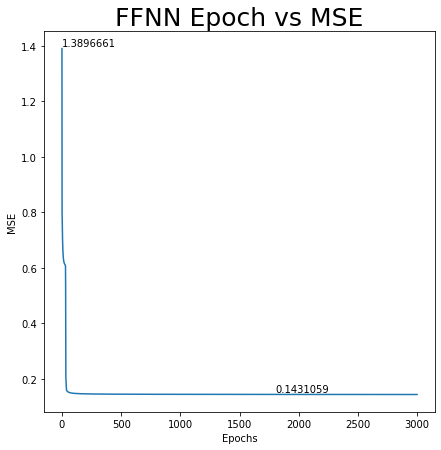

In [13]:
inputs = build_nn()
sess, e_error, t_pred = run_nn(inputs, EPOCH = 3000, model_name = "dnn")

In [6]:
test_model(df_pooled)

INFO:tensorflow:Restoring parameters from ./my-test-model
Accuracy: 71.05263157894737
